In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

### GET DATA 

In [3]:
# reading dataset using panda
data_path = os.path.dirname(os.getcwd())
data_df = pd.read_csv(os.path.join(data_path, "data/data_income.csv"))


In [4]:
data_df.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
# Define the features and target
X = data_df.drop(["income"], axis=1)
y = data_df["income"]

# Define the categorical columns to one-hot encode
categorical_cols = [
    "occupation",
    "education",
    "workclass",
    "marital-status",
    "relationship",
    "race",
    "native-country",
    "gender",
]
numeric_cols = [
    "age",
    "fnlwgt",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## XGBoost

In [7]:
# fix the format for y
y_train_bin = y_train.replace({">50K": 1, "<=50K": 0})
y_test_bin = y_test.replace({">50K": 1, "<=50K": 0})


### OneHot Encoder + Scaler

In [8]:
# Define preprocessing for categorical and numeric data
categorical_preprocessor = OneHotEncoder()
numeric_preprocessor = StandardScaler()

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_preprocessor, categorical_cols),
        ("num", numeric_preprocessor, numeric_cols),
    ],
    remainder="passthrough",  # You can use this to include any remaining columns
)

# Create a pipeline with preprocessing and the machine learning model
model = XGBClassifier(random_state=42)

pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
# Fit the pipeline (including preprocessing) to the training data
pipeline.fit(X_train, y_train_bin)
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test_bin, y_pred)
print(f"Accuracy: {accuracy:.4f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Accuracy: 0.8750


Permutation Importances:
capital-gain: 0.0514
marital-status: 0.0461
educational-num: 0.0232
age: 0.0155
occupation: 0.0154
capital-loss: 0.0113
hours-per-week: 0.0057
workclass: 0.0022
relationship: 0.0018
native-country: 0.0011
gender: 0.0010
race: -0.0000
fnlwgt: -0.0001
education: -0.0008


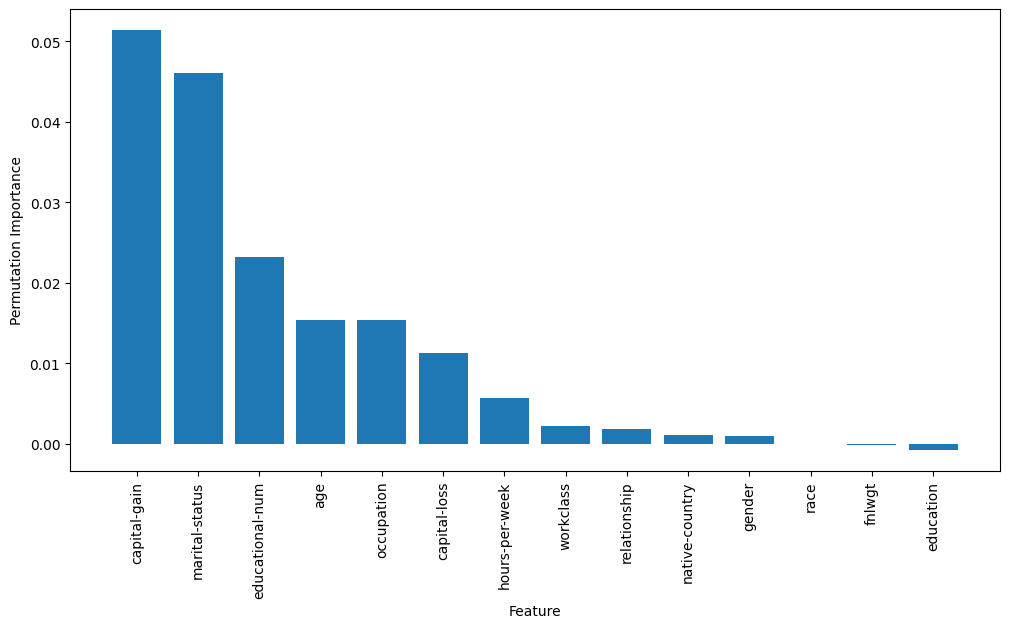

In [10]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Calculate Permutation Importance
perm_importance = permutation_importance(pipeline, X_test, y_test_bin, n_repeats=30, random_state=42)

# Get feature names and their importances
feature_names = X.columns
perm_importances = perm_importance.importances_mean

# Sort the features by their importance
sorted_idx = perm_importances.argsort()[::-1]

# Print and plot the feature importances
print("Permutation Importances:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {perm_importances[i]:.4f}")

# Create a bar chart to visualize the feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_idx)), perm_importances[sorted_idx])
# Corrected the 'plt.xticks' call
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.show()



In [ ]:
# Perform XPER analysis for a specific feature (e.g., "age")
from sklearn.inspection import plot_partial_dependence

# Replace 'age' with the feature you want to analyze
feature_to_analyze = "age"

# Fit and plot XPER for the specified feature
fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(pipeline.named_steps['model'], X_test, features=[feature_to_analyze], ax=ax)
ax.set_title(f'XPER Analysis for {feature_to_analyze}')
plt.show()